# Classification de Texte et Analyse de Sentiment

La classification de texte consiste à attribuer automatiquement une **étiquette** à un document (spam / non-spam, positif / négatif, sujet, etc.).  

L’analyse de sentiment est un cas particulier où l’on cherche à déterminer l’**opinion** exprimée dans un texte.

In [2]:
import random
import spacy
import numpy as np
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

## 1. Naive Bayes

Le classifieur **Naive Bayes** est un modèle probabiliste basé sur le théorème de Bayes.

- Hypothèse forte : les mots sont **indépendants** entre eux

- Fonctionne très bien avec des données textuelles

- Souvent utilisé comme **baseline** en NLP

**Avantages**

- Très rapide à entraîner

- Peu de données nécessaires

- Performant avec BoW ou TF-IDF

**Limites**

- Hypothèse d’indépendance irréaliste

- Moins précis sur des données complexes

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def custom_tokenizer(doc):
    return [t.text for t in nlp(doc) if not t.is_punct and not t.is_space and t.is_alpha]

train_corpus = fetch_20newsgroups(
    subset='train', 
    remove=('headers', 'footers', 'quotes'),
    categories=['sci.space', 'rec.sport.baseball', 'comp.graphics', 'talk.politics.misc']
)
test_corpus = fetch_20newsgroups(
    subset='test', 
    remove=('headers', 'footers', 'quotes'),
    categories=['sci.space', 'rec.sport.baseball', 'comp.graphics', 'talk.politics.misc']
)

train_corpus.data = train_corpus.data[:1500]
train_corpus.target = train_corpus.target[:1500]

test_corpus.data = test_corpus.data[:400]
test_corpus.target = test_corpus.target[:400]

print('Train size:', len(train_corpus.data))
print('Test size:', len(test_corpus.data))

print('\nExample article:', train_corpus.data[0])

Train size: 1500
Test size: 400

Example article: I thought that was Sandy Koufax.


In [4]:
vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer, 
    max_features=1500,
    token_pattern=None 
)

X = vectorizer.fit_transform(train_corpus.data)
y = train_corpus.target

X_test = vectorizer.transform(test_corpus.data)
y_test = test_corpus.target

clf = MultinomialNB()

clf.fit(X, y)

test_preds = clf.predict(X_test)

accuracy = np.mean(test_preds == y_test)
print(f'\nTest accuracy: {accuracy:.2%}')


Test accuracy: 81.75%


In [5]:
article = ["Nasa's Swot satellite will survey millions of rivers and lakes"]

X_article = vectorizer.transform(article)

proba_article = clf.predict_proba(X_article)

id_max = np.argmax(proba_article)
pred_article = train_corpus.target_names[id_max]
conf = np.max(proba_article)

print('\nPrediction:', pred_article)
print('Confidence:', conf)


Prediction: sci.space
Confidence: 0.9986574960537506


*Source code : `naive_bayes.py`*

## 2. Régression Logistique

La **régression logistique** est un modèle linéaire de classification.

- Apprend une frontière de décision entre les classes

- Fonctionne bien avec des vecteurs TF-IDF

- Fournit des probabilités de classe

**Avantages**

- Interprétable

- Bonne performance en pratique

- Standard industriel pour la classification de texte

**Limites**

- Modèle linéaire

- Ne capture pas la sémantique profonde

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

categories = ['sci.space', 'rec.autos']

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

print(f"Documents chargés : {len(newsgroups_train.data)}")
print(f"Exemple de classe : 0={newsgroups_train.target_names[0]}, 1={newsgroups_train.target_names[1]}")

Documents chargés : 1187
Exemple de classe : 0=rec.autos, 1=sci.space


In [7]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target

clf = LogisticRegression()
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print(f"\nPrécision (Accuracy) sur le test set : {score:.2%}")

feature_names = vectorizer.get_feature_names_out()
coefs = clf.coef_[0]

top_positive = np.argsort(coefs)[-10:]
top_negative = np.argsort(coefs)[:10]

print("\nMots clés pour 'rec.autos' (Poids Négatifs) :")
print([feature_names[i] for i in top_negative])

print("\nMots clés pour 'sci.space' (Poids Positifs) :")
print([feature_names[i] for i in top_positive])


Précision (Accuracy) sur le test set : 98.35%

Mots clés pour 'rec.autos' (Poids Négatifs) :
['car', 'cars', 'my', 'com', 'hp', 'engine', 'dealer', 'ford', 'auto', 'good']

Mots clés pour 'sci.space' (Poids Positifs) :
['alaska', 'pat', 'henry', 'of', 'orbit', 'digex', 'moon', 'access', 'nasa', 'space']


In [8]:
sample = ["Tesla vehicles run entirely on electricity and not on diesel fuel."]
pred = clf.predict(vectorizer.transform(sample))

print(f"\nPhrase : '{sample[0]}'")

print(f"Prédiction : {newsgroups_train.target_names[pred[0]]}")


Phrase : 'Tesla vehicles run entirely on electricity and not on diesel fuel.'
Prédiction : rec.autos


*Source code : `log_reg.py`*

## 3. Analyse de Sentiment (NLTK `movie_reviews`)

Le corpus `movie_reviews` de NLTK contient :

- des critiques de films

- deux classes : `positive` et `negative`

Pipeline typique :

1. Chargement du corpus

2. Vectorisation (TF-IDF)

3. Entraînement d’une **régression logistique**

4. Évaluation des performances

**Objectif** : Prédire automatiquement si une critique est **positive ou négative**.

In [9]:
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

documents = []

for fileid in movie_reviews.fileids('pos'):
    documents.append((movie_reviews.raw(fileid), 1))
    
for fileid in movie_reviews.fileids('neg'):
    documents.append((movie_reviews.raw(fileid), 0))

random.seed(1001) 
random.shuffle(documents)

X = [d[0] for d in documents]
y = [d[1] for d in documents]

print(f"Nombre total de critiques : {len(X)}")
print(f"Exemple de critique :\n{X[0][:100]}...")

Nombre total de critiques : 2000
Exemple de critique :
in 1994 , an insider's look at a scandal-ridden run for the democratic presidential nomination ( clo...


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1001)

vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train_vec, y_train)

accuracy = accuracy_score(y_test, clf.predict(X_test_vec))
print(f"\nPrécision du modèle (Accuracy) : {accuracy:.2%}")


Précision du modèle (Accuracy) : 86.00%


In [11]:
my_review = ["The movie lacked special effects and the acting was not up to the standard of the budget allocated"]
pred = clf.predict(vectorizer.transform(my_review))
print(f"\nTest manuel : '{my_review[0]}'")
print(f"Résultat : {'POSITIF' if pred[0] == 1 else 'NÉGATIF'}")


Test manuel : 'The movie lacked special effects and the acting was not up to the standard of the budget allocated'
Résultat : NÉGATIF


*Source code : `sent_analysis.py`*

## 4. Métriques d’évaluation

### Precision

**Parmi les prédictions positives, combien sont correctes ?**

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

---

### Recall

Parmi les vrais positifs, combien ont été détectés ?

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

---

### F1-score

- Moyenne harmonique entre precision et recall

- Très utilisée en NLP lorsque les classes sont déséquilibrées

$$
\text{F1} = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$

--- Rapport de Classification ---
              precision    recall  f1-score   support

     Négatif       0.85      0.87      0.86       197
     Positif       0.87      0.85      0.86       203

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



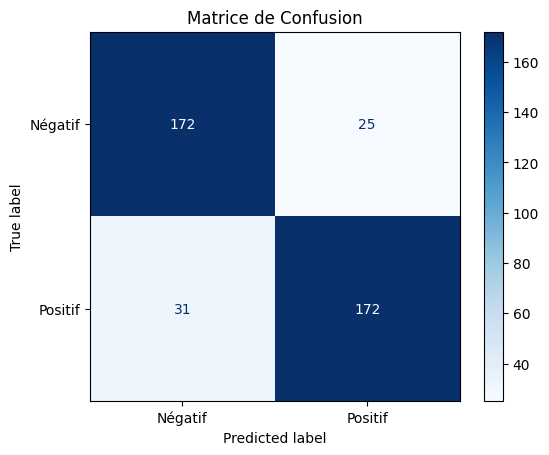

In [12]:
y_pred = clf.predict(X_test_vec)

print("--- Rapport de Classification ---")
print(classification_report(y_test, y_pred, target_names=['Négatif', 'Positif']))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Négatif', 'Positif'])
disp.plot(cmap='Blues')
plt.title("Matrice de Confusion")
plt.show()

*Source code : `sent_analysis.py`*

## Résumé

| Élément | Rôle |
|------|-----|
| Naive Bayes | Baseline rapide |
| Régression logistique | Classifieur robuste |
| Movie reviews | Corpus d’analyse de sentiment |
| Precision | Qualité des prédictions positives |
| Recall | Capacité de détection |
| F1-score | Compromis global |

En pratique, **TF-IDF + Régression Logistique + F1-score** constitue une approche simple, efficace et standard pour la classification de texte.